# 分布式 Logistic 回归模型

### 1. 准备工作

配置和启动 PySpark：

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
# 本地模式
spark = SparkSession.builder.master("local[*]").appName("Reading Text").getOrCreate()
sc = spark.sparkContext
# sc.setLogLevel("ERROR")
print(spark)
print(sc)

<SparkContext master=local[*] appName=Reading Text>


假设 $n\gg p$，利用 Numpy 生成模拟数据，并写入文件。

In [3]:
import os
import numpy as np
from scipy.special import expit, logit
np.set_printoptions(linewidth=100)

np.random.seed(123)
n = 100000
p = 100
x = np.random.normal(size=(n, p))
beta = np.random.normal(size=p)
prob = expit(x.dot(beta))  # p = 1 / (1 + exp(-x * beta))
y = np.random.binomial(1, prob, size=n)
dat = np.hstack((y.reshape(n, 1), x))
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)
np.savetxt("data/logistic.txt", dat, fmt="%f", delimiter="\t")

其中 `expit()` 即 Sigmoid 函数，表达式为 $\rho(x)=1/(1+e^{-x})$。 

PySpark 读取文件并进行一些简单操作：

In [4]:
file = sc.textFile("data/logistic.txt")

# 打印矩阵行数
print(file.count())

# 空行
print()

# 打印前5行，并将每行字符串截尾
text = file.map(lambda x: x[:70] + "...").take(5)
print(*text, sep="\n")

100000

0.000000	-1.085631	0.997345	0.282978	-1.506295	-0.578600	1.651437	-2.4...
1.000000	0.642055	-1.977888	0.712265	2.598304	-0.024626	0.034142	0.179...
0.000000	0.703310	-0.598105	2.200702	0.688297	-0.006307	-0.206662	-0.0...
1.000000	0.765055	-0.828989	-0.659151	0.611124	-0.144013	1.316606	-0.7...
0.000000	1.534090	-0.529914	-0.490972	-1.309165	-0.008660	0.976813	-1....


### 2. 牛顿法迭代

Logistic 回归的系数估计没有显式解，但可以利用牛顿法迭代。参见 [https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2](https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2)。

迭代公式为 $\beta^{new}=(X'WX)^{-1}X'Wz$，其中 $z=X\beta^{old}+W^{-1}(y-prob)$，$prob$ 是 $\rho(X\beta^{old})$ 组成的向量，$W$ 是以 $prob\cdot (1-prob)$ 为对角线元素的对角矩阵。

当 $n\gg p$ 且 $p$ 不太大时，$X'WX$ 为 $p\times p$ 矩阵，$X'Wz$ 为 $p\times 1$ 向量，均可放入内存。因此，此时问题的核心在于计算 $X'WX$ 与 $X'Wz$。

首先进行分区映射：

In [5]:
# file = file.repartition(10)
print(file.getNumPartitions())

3


In [6]:
# str => np.array
def str_to_vec(line):
    # 分割字符串
    str_vec = line.split("\t")
    # 将每一个元素从字符串变成数值型
    num_vec = map(lambda s: float(s), str_vec)
    # 创建 Numpy 向量
    return np.fromiter(num_vec, dtype=float)

# Iter[str] => Iter[matrix]
def part_to_mat(iterator):
    # Iter[str] => Iter[np.array]
    iter_arr = map(str_to_vec, iterator)

    # Iter[np.array] => list(np.array)
    dat = list(iter_arr)

    # list(np.array) => matrix
    if len(dat) < 1:  # Test zero iterator
        mat = np.array([])
    else:
        mat = np.vstack(dat)

    # matrix => Iter[matrix]
    yield mat

In [7]:
dat = file.mapPartitions(part_to_mat).filter(lambda x: x.shape[0] > 0)
print(dat.count())
dat.cache()

3


PythonRDD[5] at RDD at PythonRDD.scala:53

In [8]:
dat.first()

array([[ 0.      , -1.085631,  0.997345, ..., -1.363472,  0.379401, -0.379176],
       [ 1.      ,  0.642055, -1.977888, ..., -0.110851, -0.341262, -0.217946],
       [ 0.      ,  0.70331 , -0.598105, ...,  0.415695,  0.160544,  0.819761],
       ...,
       [ 0.      ,  0.348678, -2.078281, ..., -1.108426, -1.385233, -0.173929],
       [ 0.      , -1.716787,  0.370369, ..., -0.125681, -0.398374, -0.987013],
       [ 0.      ,  0.86831 , -0.9381  , ...,  0.023153, -0.897204,  0.535759]])

注意此时每个分区上的数据同时包含了因变量 $y$ 和自变量 $X$。给定当前估计 $\beta^{old}$，计算每个分区上的统计量 $X'WX$ 和 $X'Wz$：

In [9]:
def compute_stats(part_mat, beta_old):
    # 提取 X 和 y
    y = part_mat[:, 0]
    x = part_mat[:, 1:]
    
    # X * beta
    xb = x.dot(beta_old)

    # rho(X * beta)
    prob = expit(xb)

    # W 的对角线元素
    w = prob * (1.0 - prob) + 1e-6

    # X'W，数组广播操作，避免生成完整的 W
    xtw = x.transpose() * w

    # X'WX
    xtwx = xtw.dot(x)

    # X'Wz
    z = xb + (y - prob) / w

    xtwz = xtw.dot(z)

    # 目标函数：sum(y * log(prob) + (1 - y) * log(1 - prob))
    objfn = -np.sum(y * np.log(prob + 1e-8) + (1.0 - y) * np.log(1.0 - prob + 1e-8))
    return xtwx, xtwz, objfn

主循环：

In [10]:
import time

# 根据数据动态获取维度，不要使用之前模拟时的变量
p = dat.first().shape[1] - 1
# beta 初始化为 0 向量
beta_hat = np.zeros(p)
# 记录目标函数值
objvals = []

# 最大迭代次数
maxit = 30
# 收敛条件
eps = 1e-6

t1 = time.time()
for i in range(maxit):
    # 完整数据的 X'WX 和 X'Wz 是各分区的加和
    xtwx, xtwz, objfn = dat.map(lambda part: compute_stats(part, beta_hat)).\
        reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
    # 计算新 beta
    beta_new = np.linalg.solve(xtwx, xtwz)
    # 计算 beta 的变化
    resid = np.linalg.norm(beta_new - beta_hat)
    print(f"Iteration {i}, objfn = {objfn}, resid = {resid}")
    objvals.append(objfn)
    # 如果 beta 几乎不再变化，退出循环
    if resid < eps:
        break
    # 更新 beta
    beta_hat = beta_new
t2 = time.time()
print(f"\nfinished in {t2 - t1} seconds")

Iteration 0, objfn = 69314.71605599453, resid = 1.5704037438983012
Iteration 1, objfn = 32637.520394548366, resid = 1.3912432651305582
Iteration 2, objfn = 21628.543193119614, resid = 1.739334124843481
Iteration 3, objfn = 16007.123573787421, resid = 2.0827596366952847
Iteration 4, objfn = 13331.19693435778, resid = 2.0636707533919356
Iteration 5, objfn = 12380.364067131335, resid = 1.3200627482589729
Iteration 6, objfn = 12209.479535070568, resid = 0.35165728836328636
Iteration 7, objfn = 12201.99376346888, resid = 0.018832519429069088
Iteration 8, objfn = 12201.974858771522, resid = 6.669254090501773e-05
Iteration 9, objfn = 12201.97485851805, resid = 6.386265811366258e-08

finished in 14.6397225856781 seconds


绘制目标函数变化曲线：

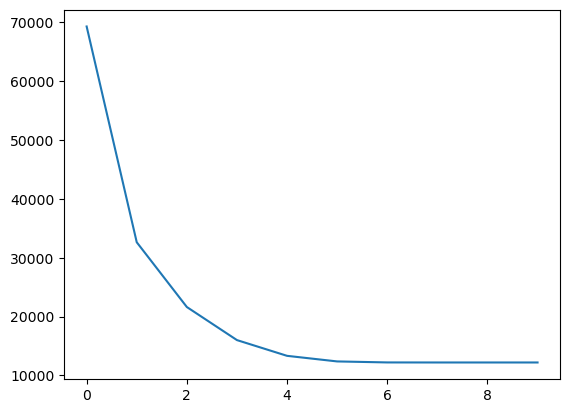

In [11]:
import matplotlib.pyplot as plt
plt.plot(objvals)

### 3. 梯度下降法迭代

迭代公式为 $\beta^{new}=\beta^{old}-\alpha\cdot n^{-1}X'(prob-y)$，其中 $prob$ 是 $\rho(X\beta^{old})$ 组成的向量。

1/n的作用是求解一个平均的损失函数，避免随着n的增长而增长

由后面的迭代结果也可以发现梯度下降对于优化算法而言是相对低效的

单次迭代的时间复杂度为$O(np)$

梯度 存储开销小，计算方便，故在DL等应用场景当$p$很大时只能使用梯降法

In [12]:
def compute_obj_grad(part_mat, beta_old):
    # 提取 X 和 y
    y = part_mat[:, 0]
    x = part_mat[:, 1:]
    # X * beta
    xb = x.dot(beta_old)
    # rho(X * beta)
    prob = expit(xb)
    # 目标函数：sum(y * log(prob) + (1 - y) * log(1 - prob))
    obj = -np.sum(y * np.log(prob + 1e-8) + (1.0 - y) * np.log(1.0 - prob + 1e-8))
    # 梯度：X'(prob - y)
    grad = x.transpose().dot(prob - y)
    # 该分块的样本量
    ni = x.shape[0]
    return ni, obj, grad

主循环：

In [13]:
import time

# 根据数据动态获取维度，不要使用之前模拟时的变量
p = dat.first().shape[1] - 1
# beta 初始化为 0 向量
beta_hat2 = np.zeros(p)
# 记录目标函数值
objvals = []

# 最大迭代次数
maxit = 100
# 步长
step_size = 10.00
# 收敛条件
eps = 1e-5

t1 = time.time()
for i in range(maxit):
    # 完整数据的样本量和梯度是各分区的加和
    n, objfn, grad = dat.map(lambda part: compute_obj_grad(part, beta_hat2)).\
        reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
    objfn /= n
    grad /= n
    # 计算新 beta
    beta_new = beta_hat2 - step_size * grad
    # 计算梯度的变化
    grad_norm = np.linalg.norm(grad)
    beta_norm = np.linalg.norm(beta_hat2)
    print(f"Iteration {i}, objfn = {objfn}, grad_norm = {grad_norm}, beta_norm = {beta_norm}")
    objvals.append(objfn)
    # 如果梯度值较小，退出循环
    if grad_norm < eps or grad_norm < eps * beta_norm:
        break
    # 更新 beta
    beta_hat2 = beta_new
t2 = time.time()
print(f"\nfinished in {t2 - t1} seconds")

Iteration 0, objfn = 0.6931471605599453, grad_norm = 0.39367379557312826, beta_norm = 0.0
Iteration 1, objfn = 0.17950616436038194, grad_norm = 0.03161993154779146, beta_norm = 3.936737955731282
Iteration 2, objfn = 0.1707471024683261, grad_norm = 0.02538352751961535, beta_norm = 4.229491074256976
Iteration 3, objfn = 0.164693819270344, grad_norm = 0.02239284119114397, beta_norm = 4.483061356681379
Iteration 4, objfn = 0.15994191805009847, grad_norm = 0.020095697896829853, beta_norm = 4.7069573090021795
Iteration 5, objfn = 0.1560914605394923, grad_norm = 0.018258205753545906, beta_norm = 4.907896894608809
Iteration 6, objfn = 0.152897837488854, grad_norm = 0.016748376887099, beta_norm = 5.090465232475997
Iteration 7, objfn = 0.1502003244937587, grad_norm = 0.015481630776221283, beta_norm = 5.257937245323649
Iteration 8, objfn = 0.14788823548439792, grad_norm = 0.014400867947102375, beta_norm = 5.412743195401856
Iteration 9, objfn = 0.1458824771707256, grad_norm = 0.013465993183607725,

绘制目标函数变化曲线：

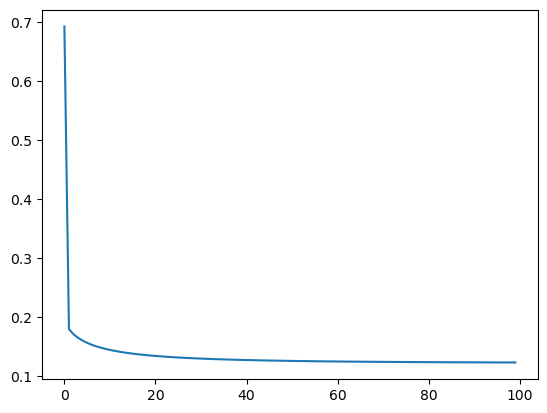

In [14]:
import matplotlib.pyplot as plt
plt.plot(objvals)

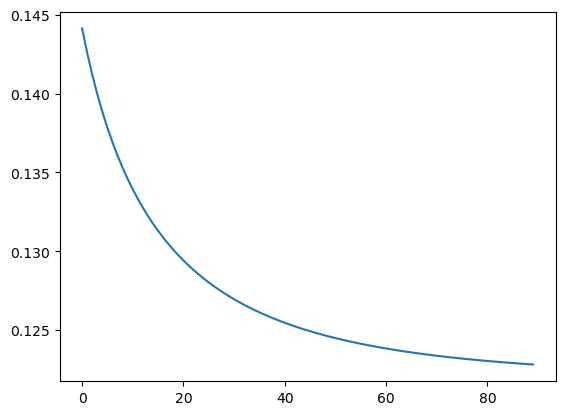

In [15]:
plt.plot(objvals[10:])

In [16]:
beta_hat[:10]

array([-0.60081137, -1.11699943,  1.18280741,  0.67081184,  0.66972214, -1.7050926 ,  0.87667438,
       -0.69162028,  1.22498276, -0.19295167])

In [17]:
beta_hat2[:10]

array([-0.53574652, -0.99449301,  1.05384849,  0.59716786,  0.59701593, -1.51937926,  0.78181547,
       -0.61447473,  1.09003962, -0.17255694])

关闭 Spark 连接：

In [18]:
sc.stop()